# GSoC 2024 ML4SCI QMLHEP Task Submission

**Name:** Haemanth Velmurugan <br>
**Email:** haemanth10@gmail.com

### Task 2

### Classical Graph Neural Network (GNN) 
For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available [here](https://zenodo.org/record/3164691#.YigdGt9MHrB) with its corresponding description. 
* Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges. 
* Discuss the resulting performance of the 2 chosen architectures. 


#### Creating the graph dataset

An elementary step towards employing GNNs is to tranform the given point-cloud data to a graph. The dataset contains samples of the form $(M, 4)$ where $M$ is the multiplicity (number of particles) in the jet $\alpha$ and $4$ denotes the number of features of each particle $i$, namely transverse momentum $p_{T,\alpha}^{(i)}$, rapidity $y_{\alpha}^{(i)}$, azimuthal angle $\phi^{(i)}$ and PDG id $I_{\alpha}^{(i)}$. 

Since each datapoint is a collection of particles, a better representation of the dataset would be to embed each datapoint in a graph. The nodes represent each particle and the edges would have to represent some meaningful relationship, such as similarity in features, between the particles. Each graph will then have a corresponding label as $0$ for gluons and $1$ for quarks.

As explained in [[1]](https://arxiv.org/pdf/2311.18672.pdf), the PDG id $I_{\alpha}^{(i)}$ can be used to extract more useful features about the particles, namely transverse mass $m^{(i)}_{T,\alpha}$, the energy $E^{(i)}_{\alpha}$, and the Cartesian momentum components, $p^{(i)}_{x,\alpha}$, $p^{(i)}_{y,\alpha}$, and $p^{(i)}_{z,\alpha}$. The feature-engineered datapoints would then have the shape $(M,8)$. 

The properties of the graph data for each jet can then be described as follows:
* **Nodes**: Particle in the jet
* **Edges**: Connects each particle to its nearest neighbour in $(\phi,y)$ space
* **Edge weight**: Euclidean distance between particles in the $(\phi,y)$ space
* **Node features**: $8$-tuple consisting of $(p_{T}, y, \phi, m_{T}, E, p_{x}, p_{y}, p_{z})$
* **Graph label**: $0$ for gluon and $1$ for quark

We connect every node to $\sqrt N$ of the nearest neighbours in a graph with $N$ nodes, to ensure a connected graph.

For this task, we will be using the pytorch-geometric framework. 

In [ ]:
!pip install energyflow
!pip install particle
!pip install torch_geometric

In [1]:
import numpy as np
import energyflow
from particle import Particle

import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch.nn import Sequential, Linear, ReLU, Sigmoid, Tanh, BCEWithLogitsLoss, Dropout, ModuleList
from torch_geometric.nn import GCNConv, SAGEConv, global_mean_pool
from torch.optim import Adam
from torch_geometric.loader import DataLoader
from tqdm import tqdm

import networkx as nx
import os
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#### Load the dataset

In [ ]:
energyflow.qg_jets.load(num_data=100000, pad=True, ncol=4, generator='pythia', with_bc=False, cache_dir='~/data')

In [2]:
dataset = np.load(os.path.expanduser('~/data/datasets/QG_jets.npz'))

In [3]:
dataset.files

['X', 'y']

In [4]:
X = dataset['X']
y = dataset['y']
X.shape, y.shape

((100000, 139, 4), (100000,))

#### Compute the new feature values

In [5]:
def feature_engineer_dataset(X):
    
    # unpack all features
    pt = X[:,:,0]
    rapidity = X[:,:,1]
    phi = X[:,:,2]
    pdgids = X[:,:,3]

    # Calculate new feature values
    nonzero_pdgids = np.where(pdgids > 0) 
    mass = np.zeros(pdgids.shape)
    mass_nonzeros = np.vectorize(Particle.from_pdgid)(pdgids[nonzero_pdgids])
    mass[nonzero_pdgids] = np.fromiter((i.mass for i in mass_nonzeros), float)

    mt = np.sqrt(np.square(mass) + np.square(pt))
    energy = mass*np.cosh(rapidity) 
    px = pt*np.cos(phi)
    py = pt*np.sin(phi)
    pz = mt*np.sinh(rapidity)
    
    return torch.tensor(np.stack((pt, rapidity, phi, mt, energy, px, py, pz), axis=2), dtype=torch.float)

In [6]:
X_new = feature_engineer_dataset(X)

In [7]:
X_new.shape, X_new.type()

(torch.Size([100000, 139, 8]), 'torch.FloatTensor')

#### Normalize the dataset

In [8]:
torch.amax(X_new, dim=(0,1))

tensor([5.4849e+02, 2.2004e+00, 6.7172e+00, 1.0556e+03, 3.7837e+03, 5.0324e+02,
        5.2501e+02, 3.6537e+03])

In [9]:
X_norm = X_new / torch.amax(X_new, dim=(0,1))   
# fetch the maximum value for all feature (in last dimension) and normalize the dataset through max scaling.

#### Visualize 1 data point

In [10]:
np.set_printoptions(suppress=True,precision=4)
X_norm[0,:,0], X_new[0,:,0]

(tensor([4.9001e-04, 2.9185e-04, 2.0943e-03, 7.5326e-03, 3.0921e-03, 3.9995e-03,
         2.9519e-03, 1.2019e-02, 6.8751e-03, 2.4579e-02, 7.4895e-03, 3.9464e-02,
         1.2353e-02, 2.4166e-02, 5.4395e-03, 6.8140e-02, 6.1149e-01, 8.0609e-02,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e

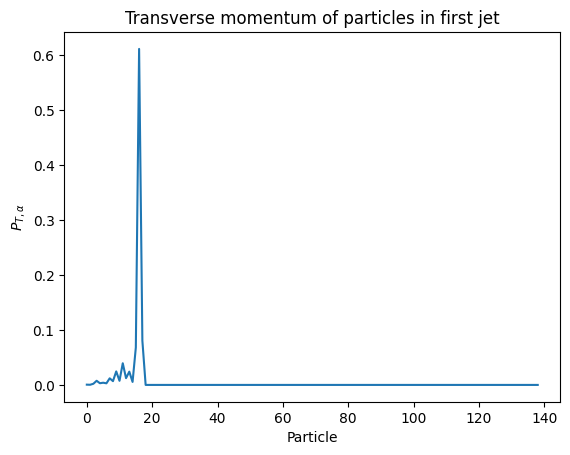

In [11]:
n = X_norm[0].shape[0]
pt = X_norm[0,:,0]
plt.plot(range(n), pt)
plt.xlabel('Particle')
plt.ylabel('$P_{T,\\alpha}$')
plt.title('Transverse momentum of particles in first jet')
plt.show()

Since there are a lot of zeros in each jet (due to zero padding), we will remove the unnecessary particles form the dataset. Moreover, GNNs can handle graph data with different number of nodes, hence this will not cause any problems with training the GNN later

In [10]:
def strip_zeros(X):
    X_useful = []
    for Xi in X:
        inds = np.where(Xi[:,0] != 0)
        X_useful.append(Xi[inds])
        
    return X_useful

In [11]:
X_preprocessed = strip_zeros(X_norm)
len(X_preprocessed), X_preprocessed[0].shape, X_preprocessed[1].shape

(100000, torch.Size([18, 8]), torch.Size([17, 8]))

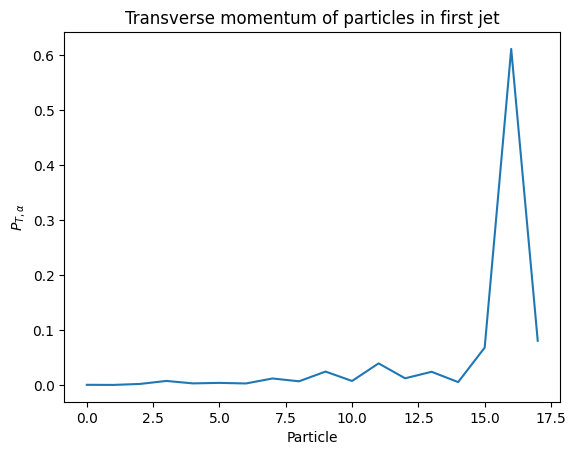

In [14]:
n = X_preprocessed[0].shape[0]
pt = X_preprocessed[0][:,0]
plt.plot(range(n), pt)
plt.xlabel('Particle')
plt.ylabel('$P_{T,\\alpha}$')
plt.title('Transverse momentum of particles in first jet')
plt.show()

In [15]:
X_preprocessed[0].dtype

torch.float32

In [16]:
np.set_printoptions(suppress=False)

#### Create graphs from data points

In torch geometric we define the graph dataset using the following attributes
* **x** - Node features
* **edge_index** - Edges (denoted by nodes forming the edges) of the graph of shape [2, num_edges] (COO format)
* **edge_attr** - Edge features
* **y** - Graph labels

In [12]:
def create_graph(x):
    M = x.shape[0]  # number of nodes in graph (particles)
    N = min(int(np.sqrt(M))+1, M)   # number of neighbors of each node to be considered for edge connections (1 extra for self loops) 
    # (√N is considered optimal number of neighbors for k-NN on N points)
    edge_index = torch.zeros((2,M*N))   
    edge_attr = torch.zeros((M*N, 1))
    
    for i,features in enumerate(x):
        # find N nearest neighbors in (𝜙,𝑦) space
        distances = torch.sqrt((features[2] - x[:,2])**2 + (features[1] - x[:,1])**2)
        N_nearest = np.argsort(distances)[:N]
        
        edge_index[0][i*N:(i+1)*N] = torch.tensor([i for _ in range(N)])
        edge_index[1][i*N:(i+1)*N] = N_nearest
        edge_attr[i*N:(i+1)*N] = distances[N_nearest].reshape(N,1)
     
    edge_index = edge_index.to(torch.int)
    return edge_index, edge_attr

Test the function

In [19]:
x = torch.tensor([[0,1,2],[0,3,4],[0,7,8],[0,4.5,4.5]])
edge_index, edge_attr = create_graph(x)
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr,y=[0])

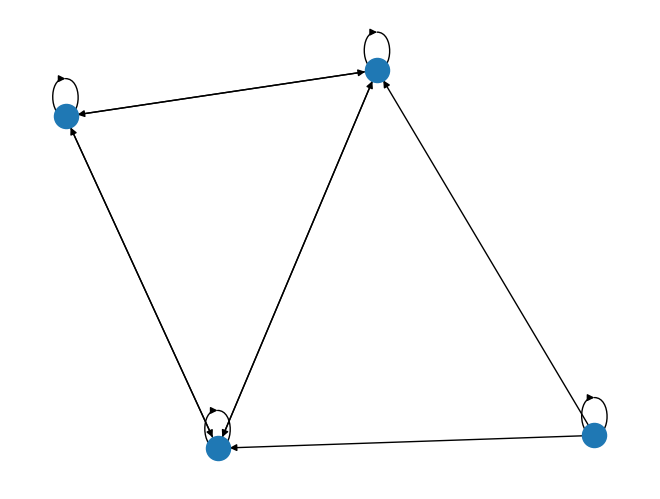

In [20]:
g = to_networkx(data, to_undirected=False)
nx.draw(g)

In [21]:
edge_index.dtype

torch.int32

In [13]:
def create_graph_dataset(X, y):
    dataset = []
        
    for Xi, yi in zip(X,y):

        edge_index, edge_attr = create_graph(Xi)            
        data = Data(x=Xi, edge_index=edge_index, edge_attr=edge_attr,y=yi)
        dataset.append(data)
        
    return dataset

In [14]:
dataset = create_graph_dataset(X_preprocessed,y)

In [15]:
len(dataset), dataset[0]

(100000, Data(x=[18, 8], edge_index=[2, 90], edge_attr=[90, 1], y=1.0))

#### Hyperparameters for GNN

In [16]:
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2
batch_size = 256

epochs = 100
lr = 5e-4

#### Prepare train, validation and test data

In [17]:
data_train, data_val, data_test = torch.utils.data.random_split(dataset, [train_ratio, val_ratio, test_ratio])

In [18]:
len(data_train), len(data_val), len(data_test)

(60000, 20000, 20000)

In [19]:
train_dataloader = DataLoader(data_train,
                              batch_size = batch_size,
                              shuffle=True)
val_dataloader = DataLoader(data_val,
                            batch_size = batch_size,
                            shuffle=True)
test_dataloader = DataLoader(data_test,
                         batch_size = batch_size,
                         shuffle=True)

In [20]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(235, 79, 79)

In [21]:
dataset[0].x.type(), dataset[0].edge_index.type()

('torch.FloatTensor', 'torch.IntTensor')

#### Implementing GNNs

#### 1. Simple Graph Convolution Neural Network (GCN)

Consider a GCN with the following three layers namely:
* Graph convolution layer
* Linear layer
* Non-linear activation

In [41]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activ_fn):
        super().__init__()
        layers = []
        layers.append(GCNConv(input_dim, hidden_dims[0]))
    
        for i in range(len(hidden_dims)-1):
            layers.append(GCNConv(hidden_dims[i], hidden_dims[i+1]))
            
        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        self.dropout = Dropout()
        self.classifier = Linear(hidden_dims[-1], output_dim)

    def forward(self, x, edge_index, batch):
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index)
            h = self.activ_fn(h)
         
        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        h = self.dropout(h)
        h = self.classifier(h)
        return h

In [42]:
model = GNN(input_dim = dataset[0].num_node_features, hidden_dims=[16,16,8],output_dim=1, activ_fn=ReLU())
model

GNN(
  (layers): ModuleList(
    (0): GCNConv(8, 16)
    (1): GCNConv(16, 16)
    (2): GCNConv(16, 8)
  )
  (activ_fn): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

Since the task at hand is binary classification, we consider only 1 output node producing the probability of the particles being gluon/quark. Hence an appropriate choice of activation function would be the sigmoid function and loss could be the Binary Cross Entropy loss. We therefore use the BCEWithLogitsLoss which handles both these operations. $\color{red}{\text{We also choose Adam optimizer with a default learning rate of $1e-3$}}$.

In [32]:
def run_model(model, epoch, loader, lossFn, optimizer, train=True):
    if train:
        model.train()
    else:
        model.eval()
        
    loss = 0
    net_loss = 0
    correct = 0
  
    for batch_idx, data in (tqdm(enumerate(loader)) if train else enumerate(loader)):
        
        target = data.y

        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()

        #Run the model on the train data
        output = model(data.x, data.edge_index.type(torch.int64), data.batch)

        target = target.unsqueeze(1).float()

        # Calculate the loss
        loss = lossFn(output, target)
        net_loss += loss.data * batch_size

        if train:
            #dloss/dx for every Variable 
            loss.backward()

            #to do a one-step update on our parameter.
            optimizer.step()

        pred = (output > 0).float()   
        correct += (pred == target).sum()
        
        
    acc = 100. * correct / len(loader.dataset)
    net_loss /= len(loader.dataset)
      
    if train:
        print('Train', end=" ")
    else:
        print("Val", end=" ")
        
    # Print out the loss
    print('Epoch: {} \tLoss: {:.6f}, Accuracy: {}/{} ({:.0f}%)'.format(
          epoch, net_loss, correct, len(loader.dataset),
          acc))
    
    return net_loss, acc

In [33]:
def train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader):
    
    history = {'train_loss': [],'val_loss':[],'train_acc': [],'val_acc': [] }

    for epoch in range(epochs):
        train_loss, train_acc = run_model(model, epoch, train_dataloader, lossFn, optimizer)
        val_loss, val_acc = run_model(model, epoch, val_dataloader, lossFn, optimizer, train=False)
        print()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
    return history    

1e-3

In [43]:
model = GNN(input_dim = dataset[0].num_node_features, hidden_dims=[16,16,8],output_dim=1, activ_fn=ReLU())

In [98]:
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

274it [00:13, 20.73it/s]


Train Epoch: 0 	Loss: 0.694372, Accuracy: 35570/70000 (51%)
Val Epoch: 0 	Loss: 0.697127, Accuracy: 7812/15000 (52%)



274it [00:15, 17.90it/s]


Train Epoch: 1 	Loss: 0.692811, Accuracy: 36733/70000 (52%)
Val Epoch: 1 	Loss: 0.693440, Accuracy: 8363/15000 (56%)



274it [00:14, 18.49it/s]


Train Epoch: 2 	Loss: 0.678052, Accuracy: 41956/70000 (60%)
Val Epoch: 2 	Loss: 0.656582, Accuracy: 10373/15000 (69%)



274it [00:15, 17.80it/s]


Train Epoch: 3 	Loss: 0.620749, Accuracy: 48294/70000 (69%)
Val Epoch: 3 	Loss: 0.583248, Accuracy: 11420/15000 (76%)



274it [00:15, 17.46it/s]


Train Epoch: 4 	Loss: 0.577808, Accuracy: 50840/70000 (73%)
Val Epoch: 4 	Loss: 0.559386, Accuracy: 11521/15000 (77%)



274it [00:14, 18.52it/s]


Train Epoch: 5 	Loss: 0.565866, Accuracy: 51379/70000 (73%)
Val Epoch: 5 	Loss: 0.552622, Accuracy: 11547/15000 (77%)



274it [00:14, 18.42it/s]


Train Epoch: 6 	Loss: 0.561182, Accuracy: 51633/70000 (74%)
Val Epoch: 6 	Loss: 0.550658, Accuracy: 11539/15000 (77%)



274it [00:15, 17.68it/s]


Train Epoch: 7 	Loss: 0.557559, Accuracy: 51559/70000 (74%)
Val Epoch: 7 	Loss: 0.563281, Accuracy: 11583/15000 (77%)



274it [00:15, 18.25it/s]


Train Epoch: 8 	Loss: 0.555461, Accuracy: 51647/70000 (74%)
Val Epoch: 8 	Loss: 0.550296, Accuracy: 11502/15000 (77%)



274it [00:14, 18.53it/s]


Train Epoch: 9 	Loss: 0.551527, Accuracy: 51785/70000 (74%)
Val Epoch: 9 	Loss: 0.546543, Accuracy: 11566/15000 (77%)



274it [00:14, 18.82it/s]


Train Epoch: 10 	Loss: 0.558525, Accuracy: 51553/70000 (74%)
Val Epoch: 10 	Loss: 0.543546, Accuracy: 11638/15000 (78%)



274it [00:14, 18.35it/s]


Train Epoch: 11 	Loss: 0.552769, Accuracy: 51856/70000 (74%)
Val Epoch: 11 	Loss: 0.541875, Accuracy: 11650/15000 (78%)



274it [00:14, 18.72it/s]


Train Epoch: 12 	Loss: 0.552318, Accuracy: 51847/70000 (74%)
Val Epoch: 12 	Loss: 0.548340, Accuracy: 11547/15000 (77%)



274it [00:14, 18.48it/s]


Train Epoch: 13 	Loss: 0.547707, Accuracy: 51852/70000 (74%)
Val Epoch: 13 	Loss: 0.541630, Accuracy: 11644/15000 (78%)



274it [00:15, 17.84it/s]


Train Epoch: 14 	Loss: 0.551673, Accuracy: 51954/70000 (74%)
Val Epoch: 14 	Loss: 0.543700, Accuracy: 11620/15000 (77%)



274it [00:15, 18.25it/s]


Train Epoch: 15 	Loss: 0.551900, Accuracy: 51974/70000 (74%)
Val Epoch: 15 	Loss: 0.540566, Accuracy: 11674/15000 (78%)



274it [00:14, 18.60it/s]


Train Epoch: 16 	Loss: 0.548485, Accuracy: 51931/70000 (74%)
Val Epoch: 16 	Loss: 0.541986, Accuracy: 11656/15000 (78%)



274it [00:14, 18.43it/s]


Train Epoch: 17 	Loss: 0.550065, Accuracy: 52166/70000 (75%)
Val Epoch: 17 	Loss: 0.542842, Accuracy: 11627/15000 (78%)



274it [00:15, 18.03it/s]


Train Epoch: 18 	Loss: 0.547240, Accuracy: 52030/70000 (74%)
Val Epoch: 18 	Loss: 0.543105, Accuracy: 11620/15000 (77%)



274it [00:15, 18.25it/s]


Train Epoch: 19 	Loss: 0.551529, Accuracy: 51873/70000 (74%)
Val Epoch: 19 	Loss: 0.539542, Accuracy: 11698/15000 (78%)



274it [00:15, 18.00it/s]


Train Epoch: 20 	Loss: 0.551179, Accuracy: 51966/70000 (74%)
Val Epoch: 20 	Loss: 0.542751, Accuracy: 11644/15000 (78%)



274it [00:14, 18.62it/s]


Train Epoch: 21 	Loss: 0.548702, Accuracy: 52009/70000 (74%)
Val Epoch: 21 	Loss: 0.540282, Accuracy: 11704/15000 (78%)



274it [00:14, 18.38it/s]


Train Epoch: 22 	Loss: 0.547371, Accuracy: 52228/70000 (75%)
Val Epoch: 22 	Loss: 0.540749, Accuracy: 11649/15000 (78%)



274it [00:18, 14.57it/s]


Train Epoch: 23 	Loss: 0.551152, Accuracy: 52062/70000 (74%)
Val Epoch: 23 	Loss: 0.541910, Accuracy: 11665/15000 (78%)



274it [00:18, 15.22it/s]


Train Epoch: 24 	Loss: 0.549230, Accuracy: 52101/70000 (74%)
Val Epoch: 24 	Loss: 0.539742, Accuracy: 11722/15000 (78%)



274it [00:16, 16.69it/s]


Train Epoch: 25 	Loss: 0.548606, Accuracy: 52057/70000 (74%)
Val Epoch: 25 	Loss: 0.539443, Accuracy: 11706/15000 (78%)



274it [00:15, 17.83it/s]


Train Epoch: 26 	Loss: 0.547427, Accuracy: 52064/70000 (74%)
Val Epoch: 26 	Loss: 0.540037, Accuracy: 11723/15000 (78%)



274it [00:15, 17.80it/s]


Train Epoch: 27 	Loss: 0.547906, Accuracy: 52172/70000 (75%)
Val Epoch: 27 	Loss: 0.539353, Accuracy: 11735/15000 (78%)



274it [00:15, 17.73it/s]


Train Epoch: 28 	Loss: 0.545062, Accuracy: 52156/70000 (75%)
Val Epoch: 28 	Loss: 0.537596, Accuracy: 11728/15000 (78%)



274it [00:14, 18.37it/s]


Train Epoch: 29 	Loss: 0.546929, Accuracy: 52237/70000 (75%)
Val Epoch: 29 	Loss: 0.542445, Accuracy: 11645/15000 (78%)



274it [00:15, 18.07it/s]


Train Epoch: 30 	Loss: 0.547378, Accuracy: 52143/70000 (74%)
Val Epoch: 30 	Loss: 0.538182, Accuracy: 11710/15000 (78%)



274it [00:15, 17.17it/s]


Train Epoch: 31 	Loss: 0.545836, Accuracy: 52210/70000 (75%)
Val Epoch: 31 	Loss: 0.538064, Accuracy: 11714/15000 (78%)



274it [00:15, 17.66it/s]


Train Epoch: 32 	Loss: 0.545689, Accuracy: 52256/70000 (75%)
Val Epoch: 32 	Loss: 0.544027, Accuracy: 11625/15000 (78%)



274it [00:15, 18.07it/s]


Train Epoch: 33 	Loss: 0.547163, Accuracy: 52128/70000 (74%)
Val Epoch: 33 	Loss: 0.539561, Accuracy: 11711/15000 (78%)



274it [00:15, 17.46it/s]


Train Epoch: 34 	Loss: 0.548014, Accuracy: 52265/70000 (75%)
Val Epoch: 34 	Loss: 0.545553, Accuracy: 11611/15000 (77%)



274it [00:16, 16.77it/s]


Train Epoch: 35 	Loss: 0.549908, Accuracy: 52160/70000 (75%)
Val Epoch: 35 	Loss: 0.538556, Accuracy: 11697/15000 (78%)



274it [00:15, 17.58it/s]


Train Epoch: 36 	Loss: 0.544949, Accuracy: 52353/70000 (75%)
Val Epoch: 36 	Loss: 0.537852, Accuracy: 11697/15000 (78%)



274it [00:14, 18.55it/s]


Train Epoch: 37 	Loss: 0.546219, Accuracy: 52234/70000 (75%)
Val Epoch: 37 	Loss: 0.537235, Accuracy: 11754/15000 (78%)



274it [00:15, 17.42it/s]


Train Epoch: 38 	Loss: 0.542593, Accuracy: 52265/70000 (75%)
Val Epoch: 38 	Loss: 0.544155, Accuracy: 11592/15000 (77%)



274it [00:15, 17.82it/s]


Train Epoch: 39 	Loss: 0.543787, Accuracy: 52290/70000 (75%)
Val Epoch: 39 	Loss: 0.540126, Accuracy: 11683/15000 (78%)



274it [00:15, 17.51it/s]


Train Epoch: 40 	Loss: 0.543393, Accuracy: 52293/70000 (75%)
Val Epoch: 40 	Loss: 0.537952, Accuracy: 11718/15000 (78%)



274it [00:16, 16.61it/s]


Train Epoch: 41 	Loss: 0.546462, Accuracy: 52362/70000 (75%)
Val Epoch: 41 	Loss: 0.541327, Accuracy: 11619/15000 (77%)



274it [00:15, 17.64it/s]


Train Epoch: 42 	Loss: 0.544084, Accuracy: 52296/70000 (75%)
Val Epoch: 42 	Loss: 0.538004, Accuracy: 11749/15000 (78%)



274it [00:15, 17.61it/s]


Train Epoch: 43 	Loss: 0.547747, Accuracy: 52312/70000 (75%)
Val Epoch: 43 	Loss: 0.536607, Accuracy: 11764/15000 (78%)



274it [00:14, 18.52it/s]


Train Epoch: 44 	Loss: 0.547385, Accuracy: 52240/70000 (75%)
Val Epoch: 44 	Loss: 0.535618, Accuracy: 11715/15000 (78%)



274it [00:15, 17.54it/s]


Train Epoch: 45 	Loss: 0.544065, Accuracy: 52354/70000 (75%)
Val Epoch: 45 	Loss: 0.537775, Accuracy: 11755/15000 (78%)



274it [00:15, 18.11it/s]


Train Epoch: 46 	Loss: 0.545466, Accuracy: 52312/70000 (75%)
Val Epoch: 46 	Loss: 0.536466, Accuracy: 11691/15000 (78%)



274it [00:15, 18.16it/s]


Train Epoch: 47 	Loss: 0.542178, Accuracy: 52395/70000 (75%)
Val Epoch: 47 	Loss: 0.536725, Accuracy: 11674/15000 (78%)



274it [00:15, 17.68it/s]


Train Epoch: 48 	Loss: 0.543769, Accuracy: 52265/70000 (75%)
Val Epoch: 48 	Loss: 0.538211, Accuracy: 11748/15000 (78%)



274it [00:15, 17.95it/s]


Train Epoch: 49 	Loss: 0.543993, Accuracy: 52355/70000 (75%)
Val Epoch: 49 	Loss: 0.533447, Accuracy: 11725/15000 (78%)



274it [00:15, 17.93it/s]


Train Epoch: 50 	Loss: 0.545690, Accuracy: 52341/70000 (75%)
Val Epoch: 50 	Loss: 0.536193, Accuracy: 11707/15000 (78%)



274it [00:15, 18.04it/s]


Train Epoch: 51 	Loss: 0.541302, Accuracy: 52409/70000 (75%)
Val Epoch: 51 	Loss: 0.534949, Accuracy: 11746/15000 (78%)



274it [00:15, 17.51it/s]


Train Epoch: 52 	Loss: 0.544093, Accuracy: 52389/70000 (75%)
Val Epoch: 52 	Loss: 0.539711, Accuracy: 11664/15000 (78%)



274it [00:15, 18.08it/s]


Train Epoch: 53 	Loss: 0.542847, Accuracy: 52337/70000 (75%)
Val Epoch: 53 	Loss: 0.535585, Accuracy: 11734/15000 (78%)



274it [00:15, 18.04it/s]


Train Epoch: 54 	Loss: 0.541360, Accuracy: 52384/70000 (75%)
Val Epoch: 54 	Loss: 0.535652, Accuracy: 11690/15000 (78%)



274it [00:15, 18.03it/s]


Train Epoch: 55 	Loss: 0.544737, Accuracy: 52517/70000 (75%)
Val Epoch: 55 	Loss: 0.535826, Accuracy: 11700/15000 (78%)



274it [00:15, 18.27it/s]


Train Epoch: 56 	Loss: 0.543315, Accuracy: 52402/70000 (75%)
Val Epoch: 56 	Loss: 0.542025, Accuracy: 11590/15000 (77%)



274it [00:15, 18.10it/s]


Train Epoch: 57 	Loss: 0.545059, Accuracy: 52485/70000 (75%)
Val Epoch: 57 	Loss: 0.537016, Accuracy: 11676/15000 (78%)



274it [00:15, 17.38it/s]


Train Epoch: 58 	Loss: 0.543081, Accuracy: 52346/70000 (75%)
Val Epoch: 58 	Loss: 0.533347, Accuracy: 11743/15000 (78%)



274it [00:15, 18.04it/s]


Train Epoch: 59 	Loss: 0.541749, Accuracy: 52342/70000 (75%)
Val Epoch: 59 	Loss: 0.537009, Accuracy: 11718/15000 (78%)



274it [00:15, 17.72it/s]


Train Epoch: 60 	Loss: 0.542690, Accuracy: 52564/70000 (75%)
Val Epoch: 60 	Loss: 0.532752, Accuracy: 11732/15000 (78%)



274it [00:15, 18.07it/s]


Train Epoch: 61 	Loss: 0.541383, Accuracy: 52552/70000 (75%)
Val Epoch: 61 	Loss: 0.533415, Accuracy: 11739/15000 (78%)



274it [00:15, 17.36it/s]


Train Epoch: 62 	Loss: 0.540732, Accuracy: 52396/70000 (75%)
Val Epoch: 62 	Loss: 0.538974, Accuracy: 11674/15000 (78%)



274it [00:14, 18.58it/s]


Train Epoch: 63 	Loss: 0.543766, Accuracy: 52370/70000 (75%)
Val Epoch: 63 	Loss: 0.533520, Accuracy: 11735/15000 (78%)



274it [00:15, 17.99it/s]


Train Epoch: 64 	Loss: 0.538264, Accuracy: 52470/70000 (75%)
Val Epoch: 64 	Loss: 0.533542, Accuracy: 11710/15000 (78%)



274it [00:16, 17.12it/s]


Train Epoch: 65 	Loss: 0.543108, Accuracy: 52475/70000 (75%)
Val Epoch: 65 	Loss: 0.533716, Accuracy: 11742/15000 (78%)



274it [00:14, 18.34it/s]


Train Epoch: 66 	Loss: 0.540964, Accuracy: 52381/70000 (75%)
Val Epoch: 66 	Loss: 0.534539, Accuracy: 11723/15000 (78%)



274it [00:15, 17.86it/s]


Train Epoch: 67 	Loss: 0.540296, Accuracy: 52455/70000 (75%)
Val Epoch: 67 	Loss: 0.531278, Accuracy: 11747/15000 (78%)



274it [00:15, 17.91it/s]


Train Epoch: 68 	Loss: 0.542399, Accuracy: 52322/70000 (75%)
Val Epoch: 68 	Loss: 0.535515, Accuracy: 11682/15000 (78%)



274it [00:15, 18.02it/s]


Train Epoch: 69 	Loss: 0.541426, Accuracy: 52445/70000 (75%)
Val Epoch: 69 	Loss: 0.531521, Accuracy: 11728/15000 (78%)



274it [00:15, 17.79it/s]


Train Epoch: 70 	Loss: 0.540755, Accuracy: 52582/70000 (75%)
Val Epoch: 70 	Loss: 0.532462, Accuracy: 11723/15000 (78%)



274it [00:15, 18.07it/s]


Train Epoch: 71 	Loss: 0.537262, Accuracy: 52479/70000 (75%)
Val Epoch: 71 	Loss: 0.531339, Accuracy: 11709/15000 (78%)



274it [00:15, 17.52it/s]


Train Epoch: 72 	Loss: 0.542558, Accuracy: 52499/70000 (75%)
Val Epoch: 72 	Loss: 0.532454, Accuracy: 11743/15000 (78%)



274it [00:15, 18.24it/s]


Train Epoch: 73 	Loss: 0.538680, Accuracy: 52583/70000 (75%)
Val Epoch: 73 	Loss: 0.532550, Accuracy: 11733/15000 (78%)



274it [00:15, 17.67it/s]


Train Epoch: 74 	Loss: 0.538613, Accuracy: 52593/70000 (75%)
Val Epoch: 74 	Loss: 0.532762, Accuracy: 11687/15000 (78%)



274it [00:15, 17.96it/s]


Train Epoch: 75 	Loss: 0.541635, Accuracy: 52509/70000 (75%)
Val Epoch: 75 	Loss: 0.532063, Accuracy: 11727/15000 (78%)



274it [00:15, 18.21it/s]


Train Epoch: 76 	Loss: 0.539189, Accuracy: 52592/70000 (75%)
Val Epoch: 76 	Loss: 0.532552, Accuracy: 11712/15000 (78%)



274it [00:15, 18.21it/s]


Train Epoch: 77 	Loss: 0.540721, Accuracy: 52607/70000 (75%)
Val Epoch: 77 	Loss: 0.529971, Accuracy: 11740/15000 (78%)



274it [00:15, 18.04it/s]


Train Epoch: 78 	Loss: 0.541095, Accuracy: 52521/70000 (75%)
Val Epoch: 78 	Loss: 0.528890, Accuracy: 11731/15000 (78%)



274it [00:15, 17.69it/s]


Train Epoch: 79 	Loss: 0.537952, Accuracy: 52567/70000 (75%)
Val Epoch: 79 	Loss: 0.529755, Accuracy: 11733/15000 (78%)



274it [00:15, 18.06it/s]


Train Epoch: 80 	Loss: 0.537695, Accuracy: 52598/70000 (75%)
Val Epoch: 80 	Loss: 0.531484, Accuracy: 11735/15000 (78%)



274it [00:14, 18.40it/s]


Train Epoch: 81 	Loss: 0.538563, Accuracy: 52551/70000 (75%)
Val Epoch: 81 	Loss: 0.528187, Accuracy: 11721/15000 (78%)



274it [00:15, 17.84it/s]


Train Epoch: 82 	Loss: 0.540809, Accuracy: 52497/70000 (75%)
Val Epoch: 82 	Loss: 0.533420, Accuracy: 11681/15000 (78%)



274it [00:15, 17.81it/s]


Train Epoch: 83 	Loss: 0.541399, Accuracy: 52573/70000 (75%)
Val Epoch: 83 	Loss: 0.532898, Accuracy: 11706/15000 (78%)



274it [00:15, 18.07it/s]


Train Epoch: 84 	Loss: 0.540230, Accuracy: 52504/70000 (75%)
Val Epoch: 84 	Loss: 0.529857, Accuracy: 11725/15000 (78%)



274it [00:15, 17.74it/s]


Train Epoch: 85 	Loss: 0.542048, Accuracy: 52389/70000 (75%)
Val Epoch: 85 	Loss: 0.527955, Accuracy: 11733/15000 (78%)



274it [00:15, 17.55it/s]


Train Epoch: 86 	Loss: 0.540346, Accuracy: 52562/70000 (75%)
Val Epoch: 86 	Loss: 0.530560, Accuracy: 11714/15000 (78%)



274it [00:14, 18.30it/s]


Train Epoch: 87 	Loss: 0.542134, Accuracy: 52501/70000 (75%)
Val Epoch: 87 	Loss: 0.525608, Accuracy: 11746/15000 (78%)



274it [00:15, 18.04it/s]


Train Epoch: 88 	Loss: 0.542231, Accuracy: 52467/70000 (75%)
Val Epoch: 88 	Loss: 0.535727, Accuracy: 11646/15000 (78%)



274it [00:15, 18.11it/s]


Train Epoch: 89 	Loss: 0.538328, Accuracy: 52548/70000 (75%)
Val Epoch: 89 	Loss: 0.527874, Accuracy: 11744/15000 (78%)



274it [00:15, 18.19it/s]


Train Epoch: 90 	Loss: 0.541454, Accuracy: 52477/70000 (75%)
Val Epoch: 90 	Loss: 0.532203, Accuracy: 11696/15000 (78%)



274it [00:15, 18.10it/s]


Train Epoch: 91 	Loss: 0.538939, Accuracy: 52554/70000 (75%)
Val Epoch: 91 	Loss: 0.525379, Accuracy: 11744/15000 (78%)



274it [00:15, 17.27it/s]


Train Epoch: 92 	Loss: 0.540196, Accuracy: 52577/70000 (75%)
Val Epoch: 92 	Loss: 0.531597, Accuracy: 11739/15000 (78%)



274it [00:15, 17.92it/s]


Train Epoch: 93 	Loss: 0.538725, Accuracy: 52556/70000 (75%)
Val Epoch: 93 	Loss: 0.528148, Accuracy: 11703/15000 (78%)



274it [00:15, 18.10it/s]


Train Epoch: 94 	Loss: 0.537050, Accuracy: 52628/70000 (75%)
Val Epoch: 94 	Loss: 0.527788, Accuracy: 11742/15000 (78%)



274it [00:15, 17.99it/s]


Train Epoch: 95 	Loss: 0.537839, Accuracy: 52653/70000 (75%)
Val Epoch: 95 	Loss: 0.529816, Accuracy: 11701/15000 (78%)



274it [00:15, 17.97it/s]


Train Epoch: 96 	Loss: 0.537464, Accuracy: 52597/70000 (75%)
Val Epoch: 96 	Loss: 0.526331, Accuracy: 11740/15000 (78%)



274it [00:15, 18.12it/s]


Train Epoch: 97 	Loss: 0.540218, Accuracy: 52406/70000 (75%)
Val Epoch: 97 	Loss: 0.527354, Accuracy: 11741/15000 (78%)



274it [00:15, 18.16it/s]


Train Epoch: 98 	Loss: 0.539460, Accuracy: 52687/70000 (75%)
Val Epoch: 98 	Loss: 0.528802, Accuracy: 11705/15000 (78%)



274it [00:15, 18.05it/s]


Train Epoch: 99 	Loss: 0.539648, Accuracy: 52629/70000 (75%)
Val Epoch: 99 	Loss: 0.527005, Accuracy: 11723/15000 (78%)



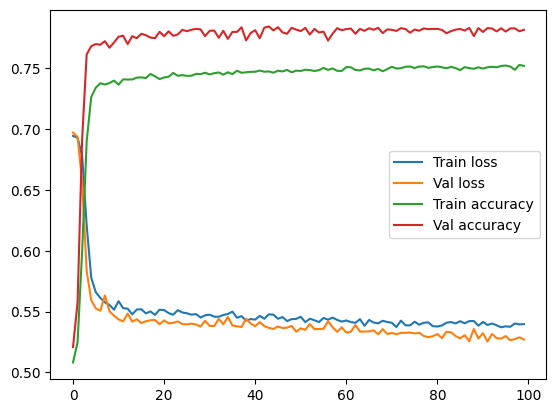

In [99]:
x = range(epochs)
plt.plot(x, history['train_loss'], label='Train loss')
plt.plot(x, history['val_loss'], label='Val loss')
plt.plot(x, np.array(history['train_acc'])/100, label='Train accuracy')
plt.plot(x, np.array(history['val_acc'])/100, label='Val accuracy')

plt.legend()
plt.show()

Test accuracy

In [100]:
preds = []
labels = []
acc = 0
for data in test_dataloader:
        
    target = data.y
    labels += target

    output = model(data.x, data.edge_index, data.batch)    
    probs = Sigmoid()(output).detach()
    preds += copy.deepcopy(probs)

    target = target.unsqueeze(1).float()    
    pred = (output > 0).float()    
    acc += (pred == target).sum()

acc = 100. * acc / len(test_dataloader.dataset)
print(acc)

tensor(77.6667)


C:\Users\HAEMANTH\anaconda3\envs\py311\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\HAEMANTH\anaconda3\envs\py311\Lib\site-packages\sklearn\utils\_array_api.py:380: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order,

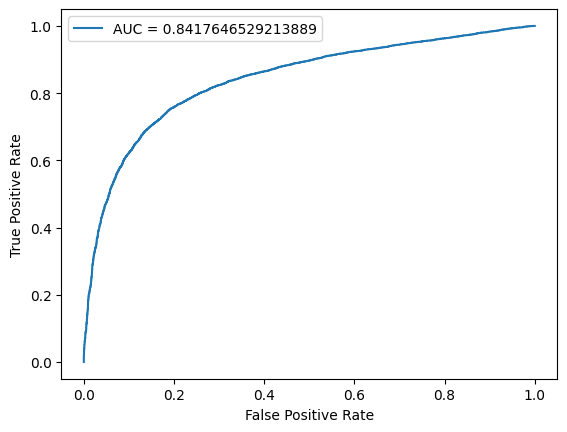

In [103]:
auc = roc_auc_score(labels, preds)
fpr, tpr, _ = roc_curve(labels, preds)
plt.plot(fpr, tpr, label="AUC = {0}".format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### 2. GraphSAGE Model

The second model replaces the Graph Convolution layer with the generalized GraphSAGE approach proposed in [Inductive Representation Learning on Large Graphs](https://arxiv.org/abs/1706.02216)

In [54]:
class GNN_Sage(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activ_fn):
        super().__init__()
        layers = []
        layers.append(SAGEConv(input_dim, hidden_dims[0]))
    
        for i in range(len(hidden_dims)-1):
            layers.append(SAGEConv(hidden_dims[i], hidden_dims[i+1]))
            
        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        self.dropout = Dropout()
        self.classifier = Linear(hidden_dims[-1], output_dim)

    def forward(self, x, edge_index, batch):
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index)
            h = self.activ_fn(h)
         
        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        h = self.dropout(h)
        h = self.classifier(h)
        return h

In [76]:
model = GNN_Sage(input_dim = dataset[0].num_node_features, hidden_dims=[16,16,8],output_dim=1, activ_fn=ReLU())
model

GNN_Sage(
  (layers): ModuleList(
    (0): SAGEConv(8, 16, aggr=mean)
    (1): SAGEConv(16, 16, aggr=mean)
    (2): SAGEConv(16, 8, aggr=mean)
  )
  (activ_fn): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

In [77]:
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-12)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

235it [00:19, 11.88it/s]


Train Epoch: 0 	Loss: 0.695015, Accuracy: 30722/60000 (51%)
Val Epoch: 0 	Loss: 0.693979, Accuracy: 11753/20000 (59%)



235it [00:17, 13.76it/s]


Train Epoch: 1 	Loss: 0.635914, Accuracy: 39261/60000 (65%)
Val Epoch: 1 	Loss: 0.549149, Accuracy: 15423/20000 (77%)



235it [00:16, 14.25it/s]


Train Epoch: 2 	Loss: 0.567696, Accuracy: 43917/60000 (73%)
Val Epoch: 2 	Loss: 0.520235, Accuracy: 15493/20000 (77%)



235it [00:18, 12.44it/s]


Train Epoch: 3 	Loss: 0.560379, Accuracy: 44085/60000 (73%)
Val Epoch: 3 	Loss: 0.515709, Accuracy: 15456/20000 (77%)



235it [00:14, 15.67it/s]


Train Epoch: 4 	Loss: 0.557080, Accuracy: 44231/60000 (74%)
Val Epoch: 4 	Loss: 0.516894, Accuracy: 15366/20000 (77%)



235it [00:12, 18.22it/s]


Train Epoch: 5 	Loss: 0.559092, Accuracy: 44200/60000 (74%)
Val Epoch: 5 	Loss: 0.508540, Accuracy: 15540/20000 (78%)



235it [00:11, 19.74it/s]


Train Epoch: 6 	Loss: 0.553944, Accuracy: 44135/60000 (74%)
Val Epoch: 6 	Loss: 0.508025, Accuracy: 15492/20000 (77%)



235it [00:11, 19.92it/s]


Train Epoch: 7 	Loss: 0.554098, Accuracy: 44418/60000 (74%)
Val Epoch: 7 	Loss: 0.509614, Accuracy: 15496/20000 (77%)



235it [00:11, 20.37it/s]


Train Epoch: 8 	Loss: 0.554580, Accuracy: 44115/60000 (74%)
Val Epoch: 8 	Loss: 0.505349, Accuracy: 15534/20000 (78%)



235it [00:11, 20.56it/s]


Train Epoch: 9 	Loss: 0.554308, Accuracy: 44154/60000 (74%)
Val Epoch: 9 	Loss: 0.506054, Accuracy: 15531/20000 (78%)



235it [00:11, 21.07it/s]


Train Epoch: 10 	Loss: 0.552144, Accuracy: 44271/60000 (74%)
Val Epoch: 10 	Loss: 0.507513, Accuracy: 15431/20000 (77%)



235it [00:10, 23.03it/s]


Train Epoch: 11 	Loss: 0.553835, Accuracy: 44267/60000 (74%)
Val Epoch: 11 	Loss: 0.506053, Accuracy: 15532/20000 (78%)



235it [00:10, 21.50it/s]


Train Epoch: 12 	Loss: 0.555905, Accuracy: 44059/60000 (73%)
Val Epoch: 12 	Loss: 0.503429, Accuracy: 15512/20000 (78%)



235it [00:11, 20.80it/s]


Train Epoch: 13 	Loss: 0.552152, Accuracy: 44148/60000 (74%)
Val Epoch: 13 	Loss: 0.503479, Accuracy: 15507/20000 (78%)



235it [00:13, 17.86it/s]


Train Epoch: 14 	Loss: 0.552119, Accuracy: 44308/60000 (74%)
Val Epoch: 14 	Loss: 0.504632, Accuracy: 15518/20000 (78%)



235it [00:11, 20.43it/s]


Train Epoch: 15 	Loss: 0.551919, Accuracy: 44399/60000 (74%)
Val Epoch: 15 	Loss: 0.504081, Accuracy: 15535/20000 (78%)



235it [00:11, 21.15it/s]


Train Epoch: 16 	Loss: 0.551209, Accuracy: 44205/60000 (74%)
Val Epoch: 16 	Loss: 0.507107, Accuracy: 15375/20000 (77%)



235it [00:11, 20.82it/s]


Train Epoch: 17 	Loss: 0.553838, Accuracy: 44289/60000 (74%)
Val Epoch: 17 	Loss: 0.509402, Accuracy: 15393/20000 (77%)



235it [00:12, 19.40it/s]


Train Epoch: 18 	Loss: 0.552026, Accuracy: 44281/60000 (74%)
Val Epoch: 18 	Loss: 0.502280, Accuracy: 15564/20000 (78%)



235it [00:11, 21.20it/s]


Train Epoch: 19 	Loss: 0.550138, Accuracy: 44263/60000 (74%)
Val Epoch: 19 	Loss: 0.504705, Accuracy: 15481/20000 (77%)



235it [00:10, 22.05it/s]


Train Epoch: 20 	Loss: 0.552998, Accuracy: 44266/60000 (74%)
Val Epoch: 20 	Loss: 0.506359, Accuracy: 15407/20000 (77%)



235it [00:10, 22.12it/s]


Train Epoch: 21 	Loss: 0.551017, Accuracy: 44389/60000 (74%)
Val Epoch: 21 	Loss: 0.502397, Accuracy: 15553/20000 (78%)



235it [00:11, 20.76it/s]


Train Epoch: 22 	Loss: 0.552198, Accuracy: 44315/60000 (74%)
Val Epoch: 22 	Loss: 0.502407, Accuracy: 15528/20000 (78%)



235it [00:12, 18.38it/s]


Train Epoch: 23 	Loss: 0.549873, Accuracy: 44316/60000 (74%)
Val Epoch: 23 	Loss: 0.503757, Accuracy: 15525/20000 (78%)



235it [00:11, 20.28it/s]


Train Epoch: 24 	Loss: 0.548486, Accuracy: 44307/60000 (74%)
Val Epoch: 24 	Loss: 0.500181, Accuracy: 15555/20000 (78%)



235it [00:11, 21.20it/s]


Train Epoch: 25 	Loss: 0.550209, Accuracy: 44294/60000 (74%)
Val Epoch: 25 	Loss: 0.502218, Accuracy: 15496/20000 (77%)



235it [00:11, 20.68it/s]


Train Epoch: 26 	Loss: 0.551517, Accuracy: 44370/60000 (74%)
Val Epoch: 26 	Loss: 0.503600, Accuracy: 15519/20000 (78%)



235it [00:10, 22.43it/s]


Train Epoch: 27 	Loss: 0.550346, Accuracy: 44331/60000 (74%)
Val Epoch: 27 	Loss: 0.504357, Accuracy: 15484/20000 (77%)



235it [00:10, 22.46it/s]


Train Epoch: 28 	Loss: 0.549165, Accuracy: 44432/60000 (74%)
Val Epoch: 28 	Loss: 0.501714, Accuracy: 15518/20000 (78%)



235it [00:10, 21.61it/s]


Train Epoch: 29 	Loss: 0.546613, Accuracy: 44389/60000 (74%)
Val Epoch: 29 	Loss: 0.504663, Accuracy: 15434/20000 (77%)



235it [00:11, 20.68it/s]


Train Epoch: 30 	Loss: 0.551104, Accuracy: 44430/60000 (74%)
Val Epoch: 30 	Loss: 0.502087, Accuracy: 15562/20000 (78%)



235it [00:11, 20.70it/s]


Train Epoch: 31 	Loss: 0.550556, Accuracy: 44311/60000 (74%)
Val Epoch: 31 	Loss: 0.503555, Accuracy: 15552/20000 (78%)



235it [00:11, 21.04it/s]


Train Epoch: 32 	Loss: 0.548998, Accuracy: 44284/60000 (74%)
Val Epoch: 32 	Loss: 0.501104, Accuracy: 15526/20000 (78%)



235it [00:11, 20.90it/s]


Train Epoch: 33 	Loss: 0.549363, Accuracy: 44427/60000 (74%)
Val Epoch: 33 	Loss: 0.505522, Accuracy: 15454/20000 (77%)



235it [00:10, 21.45it/s]


Train Epoch: 34 	Loss: 0.551869, Accuracy: 44310/60000 (74%)
Val Epoch: 34 	Loss: 0.505850, Accuracy: 15446/20000 (77%)



235it [00:10, 22.25it/s]


Train Epoch: 35 	Loss: 0.547371, Accuracy: 44346/60000 (74%)
Val Epoch: 35 	Loss: 0.500555, Accuracy: 15537/20000 (78%)



235it [00:10, 22.74it/s]


Train Epoch: 36 	Loss: 0.549117, Accuracy: 44332/60000 (74%)
Val Epoch: 36 	Loss: 0.499142, Accuracy: 15520/20000 (78%)



235it [00:11, 20.38it/s]


Train Epoch: 37 	Loss: 0.547639, Accuracy: 44415/60000 (74%)
Val Epoch: 37 	Loss: 0.502360, Accuracy: 15547/20000 (78%)



235it [00:11, 20.76it/s]


Train Epoch: 38 	Loss: 0.548851, Accuracy: 44466/60000 (74%)
Val Epoch: 38 	Loss: 0.502230, Accuracy: 15531/20000 (78%)



235it [00:11, 20.86it/s]


Train Epoch: 39 	Loss: 0.547837, Accuracy: 44465/60000 (74%)
Val Epoch: 39 	Loss: 0.503190, Accuracy: 15476/20000 (77%)



235it [00:11, 20.54it/s]


Train Epoch: 40 	Loss: 0.546483, Accuracy: 44432/60000 (74%)
Val Epoch: 40 	Loss: 0.499967, Accuracy: 15524/20000 (78%)



235it [00:11, 21.22it/s]


Train Epoch: 41 	Loss: 0.547961, Accuracy: 44464/60000 (74%)
Val Epoch: 41 	Loss: 0.500298, Accuracy: 15517/20000 (78%)



235it [00:10, 22.58it/s]


Train Epoch: 42 	Loss: 0.549039, Accuracy: 44395/60000 (74%)
Val Epoch: 42 	Loss: 0.500936, Accuracy: 15550/20000 (78%)



235it [00:10, 22.72it/s]


Train Epoch: 43 	Loss: 0.549578, Accuracy: 44504/60000 (74%)
Val Epoch: 43 	Loss: 0.499882, Accuracy: 15542/20000 (78%)



235it [00:11, 20.91it/s]


Train Epoch: 44 	Loss: 0.545597, Accuracy: 44420/60000 (74%)
Val Epoch: 44 	Loss: 0.500191, Accuracy: 15507/20000 (78%)



235it [00:11, 20.56it/s]


Train Epoch: 45 	Loss: 0.548269, Accuracy: 44443/60000 (74%)
Val Epoch: 45 	Loss: 0.498980, Accuracy: 15563/20000 (78%)



235it [00:11, 21.16it/s]


Train Epoch: 46 	Loss: 0.552892, Accuracy: 44281/60000 (74%)
Val Epoch: 46 	Loss: 0.505372, Accuracy: 15493/20000 (77%)



235it [00:11, 21.15it/s]


Train Epoch: 47 	Loss: 0.549935, Accuracy: 44398/60000 (74%)
Val Epoch: 47 	Loss: 0.505301, Accuracy: 15503/20000 (78%)



235it [00:11, 21.19it/s]


Train Epoch: 48 	Loss: 0.552130, Accuracy: 44278/60000 (74%)
Val Epoch: 48 	Loss: 0.501516, Accuracy: 15553/20000 (78%)



235it [00:10, 22.66it/s]


Train Epoch: 49 	Loss: 0.547716, Accuracy: 44494/60000 (74%)
Val Epoch: 49 	Loss: 0.502227, Accuracy: 15531/20000 (78%)



235it [00:11, 20.78it/s]


Train Epoch: 50 	Loss: 0.548129, Accuracy: 44483/60000 (74%)
Val Epoch: 50 	Loss: 0.503801, Accuracy: 15467/20000 (77%)



235it [00:10, 22.03it/s]


Train Epoch: 51 	Loss: 0.548678, Accuracy: 44437/60000 (74%)
Val Epoch: 51 	Loss: 0.501727, Accuracy: 15523/20000 (78%)



235it [00:10, 21.47it/s]


Train Epoch: 52 	Loss: 0.549806, Accuracy: 44348/60000 (74%)
Val Epoch: 52 	Loss: 0.502058, Accuracy: 15481/20000 (77%)



235it [00:11, 20.44it/s]


Train Epoch: 53 	Loss: 0.550503, Accuracy: 44342/60000 (74%)
Val Epoch: 53 	Loss: 0.501279, Accuracy: 15497/20000 (77%)



235it [00:11, 21.09it/s]


Train Epoch: 54 	Loss: 0.550874, Accuracy: 44405/60000 (74%)
Val Epoch: 54 	Loss: 0.503009, Accuracy: 15526/20000 (78%)



235it [00:11, 21.19it/s]


Train Epoch: 55 	Loss: 0.547364, Accuracy: 44456/60000 (74%)
Val Epoch: 55 	Loss: 0.501984, Accuracy: 15515/20000 (78%)



235it [00:10, 22.35it/s]


Train Epoch: 56 	Loss: 0.548300, Accuracy: 44503/60000 (74%)
Val Epoch: 56 	Loss: 0.504661, Accuracy: 15435/20000 (77%)



235it [00:10, 23.10it/s]


Train Epoch: 57 	Loss: 0.545585, Accuracy: 44525/60000 (74%)
Val Epoch: 57 	Loss: 0.504446, Accuracy: 15425/20000 (77%)



235it [00:10, 21.76it/s]


Train Epoch: 58 	Loss: 0.549516, Accuracy: 44518/60000 (74%)
Val Epoch: 58 	Loss: 0.500567, Accuracy: 15446/20000 (77%)



235it [00:11, 20.55it/s]


Train Epoch: 59 	Loss: 0.546153, Accuracy: 44582/60000 (74%)
Val Epoch: 59 	Loss: 0.503214, Accuracy: 15523/20000 (78%)



235it [00:11, 21.36it/s]


Train Epoch: 60 	Loss: 0.546404, Accuracy: 44415/60000 (74%)
Val Epoch: 60 	Loss: 0.501058, Accuracy: 15536/20000 (78%)



235it [00:11, 21.18it/s]


Train Epoch: 61 	Loss: 0.546572, Accuracy: 44512/60000 (74%)
Val Epoch: 61 	Loss: 0.502416, Accuracy: 15526/20000 (78%)



235it [00:11, 21.17it/s]


Train Epoch: 62 	Loss: 0.547164, Accuracy: 44462/60000 (74%)
Val Epoch: 62 	Loss: 0.501142, Accuracy: 15531/20000 (78%)



235it [00:10, 23.29it/s]


Train Epoch: 63 	Loss: 0.551011, Accuracy: 44423/60000 (74%)
Val Epoch: 63 	Loss: 0.500188, Accuracy: 15536/20000 (78%)



235it [00:10, 22.82it/s]


Train Epoch: 64 	Loss: 0.546221, Accuracy: 44512/60000 (74%)
Val Epoch: 64 	Loss: 0.501973, Accuracy: 15456/20000 (77%)



235it [00:11, 21.24it/s]


Train Epoch: 65 	Loss: 0.546898, Accuracy: 44540/60000 (74%)
Val Epoch: 65 	Loss: 0.500320, Accuracy: 15507/20000 (78%)



235it [00:11, 20.96it/s]


Train Epoch: 66 	Loss: 0.545652, Accuracy: 44539/60000 (74%)
Val Epoch: 66 	Loss: 0.503787, Accuracy: 15460/20000 (77%)



235it [00:11, 20.05it/s]


Train Epoch: 67 	Loss: 0.545013, Accuracy: 44625/60000 (74%)
Val Epoch: 67 	Loss: 0.500944, Accuracy: 15498/20000 (77%)



235it [00:11, 21.19it/s]


Train Epoch: 68 	Loss: 0.547098, Accuracy: 44449/60000 (74%)
Val Epoch: 68 	Loss: 0.501102, Accuracy: 15542/20000 (78%)



235it [00:11, 21.36it/s]


Train Epoch: 69 	Loss: 0.546413, Accuracy: 44452/60000 (74%)
Val Epoch: 69 	Loss: 0.501492, Accuracy: 15521/20000 (78%)



235it [00:10, 22.75it/s]


Train Epoch: 70 	Loss: 0.544863, Accuracy: 44604/60000 (74%)
Val Epoch: 70 	Loss: 0.500223, Accuracy: 15475/20000 (77%)



235it [00:10, 22.85it/s]


Train Epoch: 71 	Loss: 0.545060, Accuracy: 44580/60000 (74%)
Val Epoch: 71 	Loss: 0.499729, Accuracy: 15533/20000 (78%)



235it [00:11, 20.94it/s]


Train Epoch: 72 	Loss: 0.547024, Accuracy: 44394/60000 (74%)
Val Epoch: 72 	Loss: 0.501952, Accuracy: 15523/20000 (78%)



235it [00:12, 19.41it/s]


Train Epoch: 73 	Loss: 0.545602, Accuracy: 44525/60000 (74%)
Val Epoch: 73 	Loss: 0.503388, Accuracy: 15479/20000 (77%)



235it [00:12, 18.61it/s]


Train Epoch: 74 	Loss: 0.547293, Accuracy: 44517/60000 (74%)
Val Epoch: 74 	Loss: 0.504350, Accuracy: 15395/20000 (77%)



235it [00:11, 20.66it/s]


Train Epoch: 75 	Loss: 0.547176, Accuracy: 44538/60000 (74%)
Val Epoch: 75 	Loss: 0.503129, Accuracy: 15501/20000 (78%)



235it [00:12, 19.15it/s]


Train Epoch: 76 	Loss: 0.545662, Accuracy: 44488/60000 (74%)
Val Epoch: 76 	Loss: 0.504676, Accuracy: 15481/20000 (77%)



235it [00:13, 17.25it/s]


Train Epoch: 77 	Loss: 0.545375, Accuracy: 44613/60000 (74%)
Val Epoch: 77 	Loss: 0.498501, Accuracy: 15539/20000 (78%)



235it [00:13, 17.70it/s]


Train Epoch: 78 	Loss: 0.546474, Accuracy: 44501/60000 (74%)
Val Epoch: 78 	Loss: 0.500910, Accuracy: 15512/20000 (78%)



235it [00:13, 18.04it/s]


Train Epoch: 79 	Loss: 0.544995, Accuracy: 44501/60000 (74%)
Val Epoch: 79 	Loss: 0.499360, Accuracy: 15533/20000 (78%)



235it [00:16, 13.88it/s]


Train Epoch: 80 	Loss: 0.546019, Accuracy: 44592/60000 (74%)
Val Epoch: 80 	Loss: 0.501673, Accuracy: 15481/20000 (77%)



235it [00:18, 12.73it/s]


Train Epoch: 81 	Loss: 0.545649, Accuracy: 44618/60000 (74%)
Val Epoch: 81 	Loss: 0.499881, Accuracy: 15545/20000 (78%)



235it [00:19, 12.10it/s]


Train Epoch: 82 	Loss: 0.545447, Accuracy: 44533/60000 (74%)
Val Epoch: 82 	Loss: 0.498604, Accuracy: 15544/20000 (78%)



235it [00:11, 19.59it/s]


Train Epoch: 83 	Loss: 0.546317, Accuracy: 44476/60000 (74%)
Val Epoch: 83 	Loss: 0.500355, Accuracy: 15514/20000 (78%)



235it [00:11, 19.67it/s]


Train Epoch: 84 	Loss: 0.547467, Accuracy: 44589/60000 (74%)
Val Epoch: 84 	Loss: 0.505016, Accuracy: 15476/20000 (77%)



235it [00:13, 17.14it/s]


Train Epoch: 85 	Loss: 0.544287, Accuracy: 44629/60000 (74%)
Val Epoch: 85 	Loss: 0.506393, Accuracy: 15457/20000 (77%)



235it [00:12, 19.30it/s]


Train Epoch: 86 	Loss: 0.544930, Accuracy: 44520/60000 (74%)
Val Epoch: 86 	Loss: 0.500712, Accuracy: 15512/20000 (78%)



235it [00:11, 20.90it/s]


Train Epoch: 87 	Loss: 0.547876, Accuracy: 44552/60000 (74%)
Val Epoch: 87 	Loss: 0.501679, Accuracy: 15472/20000 (77%)



235it [00:12, 18.72it/s]


Train Epoch: 88 	Loss: 0.546323, Accuracy: 44598/60000 (74%)
Val Epoch: 88 	Loss: 0.499911, Accuracy: 15517/20000 (78%)



235it [00:11, 21.26it/s]


Train Epoch: 89 	Loss: 0.545950, Accuracy: 44483/60000 (74%)
Val Epoch: 89 	Loss: 0.501495, Accuracy: 15497/20000 (77%)



235it [00:10, 21.74it/s]


Train Epoch: 90 	Loss: 0.546176, Accuracy: 44554/60000 (74%)
Val Epoch: 90 	Loss: 0.507722, Accuracy: 15380/20000 (77%)



235it [00:10, 22.74it/s]


Train Epoch: 91 	Loss: 0.546760, Accuracy: 44565/60000 (74%)
Val Epoch: 91 	Loss: 0.502890, Accuracy: 15458/20000 (77%)



235it [00:10, 21.98it/s]


Train Epoch: 92 	Loss: 0.547278, Accuracy: 44612/60000 (74%)
Val Epoch: 92 	Loss: 0.499900, Accuracy: 15528/20000 (78%)



235it [00:11, 20.36it/s]


Train Epoch: 93 	Loss: 0.544569, Accuracy: 44680/60000 (74%)
Val Epoch: 93 	Loss: 0.501537, Accuracy: 15456/20000 (77%)



235it [00:11, 20.78it/s]


Train Epoch: 94 	Loss: 0.547035, Accuracy: 44468/60000 (74%)
Val Epoch: 94 	Loss: 0.502645, Accuracy: 15497/20000 (77%)



235it [00:11, 21.04it/s]


Train Epoch: 95 	Loss: 0.545827, Accuracy: 44515/60000 (74%)
Val Epoch: 95 	Loss: 0.503716, Accuracy: 15471/20000 (77%)



235it [00:11, 20.22it/s]


Train Epoch: 96 	Loss: 0.547086, Accuracy: 44535/60000 (74%)
Val Epoch: 96 	Loss: 0.503202, Accuracy: 15477/20000 (77%)



235it [00:10, 21.45it/s]


Train Epoch: 97 	Loss: 0.539099, Accuracy: 44732/60000 (75%)
Val Epoch: 97 	Loss: 0.499553, Accuracy: 15520/20000 (78%)



235it [00:10, 22.86it/s]


Train Epoch: 98 	Loss: 0.538119, Accuracy: 44825/60000 (75%)
Val Epoch: 98 	Loss: 0.496789, Accuracy: 15528/20000 (78%)



235it [00:10, 23.01it/s]


Train Epoch: 99 	Loss: 0.536484, Accuracy: 44946/60000 (75%)
Val Epoch: 99 	Loss: 0.497538, Accuracy: 15541/20000 (78%)



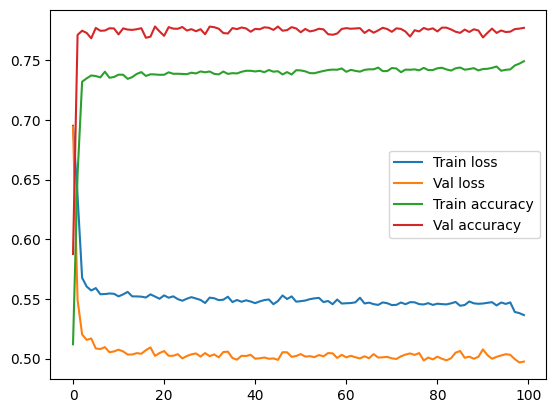

In [78]:
x = range(epochs)
plt.plot(x, history['train_loss'], label='Train loss')
plt.plot(x, history['val_loss'], label='Val loss')
plt.plot(x, np.array(history['train_acc'])/100, label='Train accuracy')
plt.plot(x, np.array(history['val_acc'])/100, label='Val accuracy')

plt.legend()
plt.show()

Test accuracy

In [79]:
preds = []
labels = []
acc = 0
for data in test_dataloader:
        
    target = data.y
    labels += target

    output = model(data.x, data.edge_index.type(torch.int64), data.batch)    
    probs = Sigmoid()(output).detach()
    preds += copy.deepcopy(probs)

    target = target.unsqueeze(1).float()    
    pred = (output > 0).float()    
    acc += (pred == target).sum()

acc = 100. * acc / len(test_dataloader.dataset)
print(acc)

tensor(77.5650)


C:\Users\HAEMANTH\anaconda3\envs\py311\Lib\site-packages\sklearn\utils\_array_api.py:380: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\HAEMANTH\anaconda3\envs\py311\Lib\site-packages\sklearn\utils\_array_api.py:380: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order,

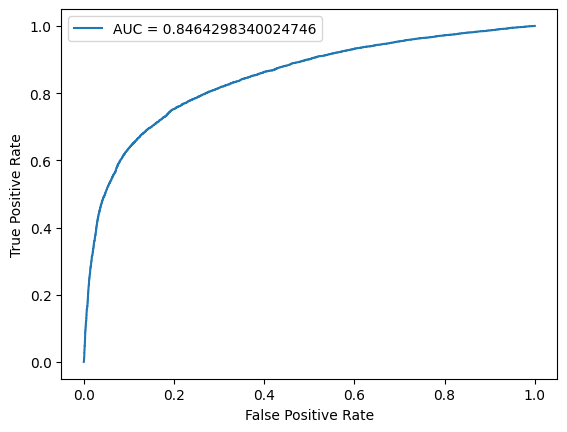

In [80]:
auc = roc_auc_score(labels, preds)
fpr, tpr, _ = roc_curve(labels, preds)
plt.plot(fpr, tpr, label="AUC = {0}".format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()